<a href="https://colab.research.google.com/github/gnsrivastava/ec_class/blob/master/ec_class_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aim:
> **To develop a machine learning model for the prediction of mixed EC class substrates**


# Background

> In biology, enzymes are categorized based on their action mechanism. For example **EC1** which is class 1 type of enzyme represents **oxidoreductase** enzyme family. The class itself is then divided into multiple categories based on the specific action of a protein on substrate active group(s).

> Most of the enzyme sunstrate reactions fall under either EC1 or EC2 class of enzyme reactions and number of reactions and corresponding substrates go down drastically from EC3 - EC7. <br>
> In the EC class substrate data there is a huge class imbalance and we require a technique to handle the imbalance.

> The EC substrate data can be devided into pure EC class molecules and mixed EC class molecules. Pure EC class molecules are the reactants that only belong to one of the EC(x) and are exclusive to that EC class.<br>
On the other hand, the mixed class molecules can belong to more than one EC class at the same time.

# Method




## Data preprocessing

> **To Do list**
1.   Find minority class(s)
2.   Compute majority to minority label weight (ratio)
3.   Define a function for upsampling of minority class based on K-neighbors
4.   Augment the orifinal data using synthetic data to counter label imbalance


### Install required packages

In [ ]:
# iterative-stratification is already installed in the repository but if faced with error please reinstall
!pip install iterative-stratification

In [ ]:
# tensorflow_addons are already installed but please reinstall incase of an error
!pip install tensorflow-addons[tensorflow]

### Import data from the home directory

In [ ]:
import pandas as pd
import numpy as np

import os
for dirname, _, filenames in os.walk('/home'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/home/upsampling.py
/home/ml_train.py
/home/mixed_ecfp.csv
/home/mixed_desc.csv
/home/mixed_fcfp.csv
/home/mixed_fp.csv


#### EDA on data

In [78]:
data_desc = pd.read_csv("/home/mixed_desc.csv", index_col=0)
#data_desc[['EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6']] = data_desc.EC1_EC2_EC3_EC4_EC5_EC6.str.split('_', expand=True)
#data_desc = data_desc.drop(columns=["EC1_EC2_EC3_EC4_EC5_EC6"])
data_desc.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,...,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,EC1_EC2_EC3_EC4_EC5_EC6
CIDs,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C00009,8.881944,-4.638889,8.881944,4.638889,0.341891,97.994,94.970,97.976895,32,0,1.200000,1.200000,1.200000,3.472066,49.783540,4.500000,2.197103,3.091530,2.000000,0.782574,2.347723,0.513277,1.539831,0.000000,0.000000,0.000000,0.000000,0.11,3.609640,5.110000,1.064830,1512.242231,28.306621,14.680235,0.0,0.0,0.000000,0.0,7.822697,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1_1_1_1_0_1
C00013,9.626875,-5.050347,9.626875,2.958333,0.407078,177.973,173.941,177.943226,56,0,0.888889,1.111111,1.111111,4.074479,147.355172,7.707107,3.908026,5.696881,3.707107,1.530297,4.590890,1.062804,3.678309,0.212726,1.914534,0.138556,1.247008,0.26,27.435741,9.260000,2.476089,8.260000,49.764010,19.573646,0.0,0.0,0.000000,0.0,15.645394,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1_1_1_1_0_1
C00014,0.000000,0.000000,0.000000,0.000000,0.397555,17.031,14.007,17.026549,8,0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.707107,0.707107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.04,0.000000,0.960000,-27.040000,-104.040000,7.504228,6.150546,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1_1_1_1_0_1
C00017,10.860741,-0.931481,10.860741,0.215832,0.407584,130.103,124.055,130.037842,50,0,1.777778,2.333333,2.666667,3.853318,172.720106,9.016508,4.495761,4.495761,4.947265,2.081214,2.081214,1.157830,1.157830,0.489278,0.489278,0.180980,0.180980,-1.10,169.853181,4.748378,1.696130,1.394403,51.841108,0.000000,0.0,0.0,0.000000,0.0,50.712056,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0_1_1_0_0_0
C00022,9.543981,-1.379630,9.543981,0.824074,0.445928,88.062,84.030,88.016044,34,0,1.500000,1.666667,1.666667,3.567703,72.039100,5.154701,3.263710,3.263710,2.642734,1.381855,1.381855,0.861339,0.861339,0.301176,0.301176,0.000000,0.000000,-0.86,13.609640,5.140000,1.545017,1.458471,34.586413,5.106527,0.0,0.0,5.783245,0.0,5.969305,4.794537,...,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1_1_1_1_0_1


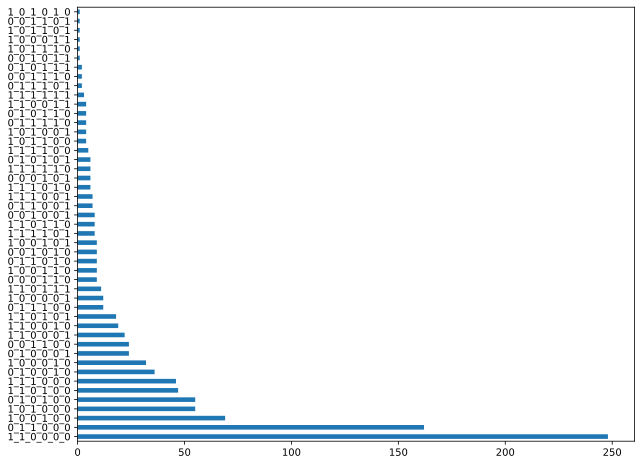

In [79]:
data_desc.iloc[:,-1].value_counts().plot(kind="barh",rot=0, figsize=(10, 8))

In [ ]:
# Correlation between data and features
#import seaborn as sns
#data_desc = data_desc.loc[:, (data_desc != 0).any(axis=0)]
#data_desc.head()
#corr1 = data_desc.corr(method='pearson')
#sns.heatmap(corr)
#corr.style.background_gradient(cmap='RdBu_r').set_precision(2)

### Get label weights and arrange them in a dataframe with labels


In [80]:
def get_label_weights(filename):
    data = pd.read_csv(filename, sep=",")
    label_count = pd.Series(data["EC1_EC2_EC3_EC4_EC5_EC6"].value_counts())
    ratio = []
    for _, value in label_count.iteritems():
        ratio.append(int((label_count.max()/value)))

    labels = pd.DataFrame(label_count.tolist(),
                      index=label_count.index, columns=["count"])
    labels["ratio"] = ratio
    return labels

In [ ]:
# print(get_label_weights("/home/mixed_desc.csv"))

### Import required packages for MLSMOTE

In [81]:
import os
import random
from sklearn.model_selection import KFold
from sklearn.neighbors import NearestNeighbors
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.layers as L
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### Define a seed for the process 

In [82]:

def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

SEED = 42
seed_everything(SEED)

In [83]:
target_cols = data_desc.iloc[:,-1]
N_TARGETS = len(target_cols)

target_cols.head()

CIDs
C00009    1_1_1_1_0_1
C00013    1_1_1_1_0_1
C00014    1_1_1_1_0_1
C00017    0_1_1_0_0_0
C00022    1_1_1_1_0_1
Name: EC1_EC2_EC3_EC4_EC5_EC6, dtype: object

In [84]:
def create_folds(df, fold_no, fold_type='mls_kfold', save=False, seed=42):
    """
    df: target dataframe
    """
    if fold_type == 'kfold':
        kf = KFold(n_splits=fold_no, shuffle=True, random_state=seed)
    elif fold_type == 'mls_kfold':
        kf = MultilabelStratifiedKFold(n_splits=fold_no, shuffle=False, random_state=seed)
        
    df['Fold'] = -1
    df.reset_index(inplace=True, drop=True)
    for fold, (t, v) in enumerate(kf.split(df, df)):
        df.loc[v, 'Fold'] = fold
    if save:
        df.to_csv('Folds.csv')
    return df

In [85]:
#N_FOLDS = 5
#fold_type = 'mls_kfold'
#y_develop = create_folds(target_cols, fold_no=N_FOLDS, fold_type=fold_type, seed=SEED)
#y_develop

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


ValueError: ignored

In [88]:
# Taken from https://github.com/niteshsukhwani/MLSMOTE, modified by Tolga Dincer.
def get_tail_label(df):
    """
    Give tail label colums of the given target dataframe
    
    args
    df: pandas.DataFrame, target label df whose tail label has to identified
    
    return
    tail_label: list, a list containing column name of all the tail label
    """
    columns = df.columns
    n = len(columns)
    irpl = np.zeros(n)
    for column in range(n):
        irpl[column] = df[columns[column]].value_counts()[1]
    irpl = max(irpl)/irpl
    mir = np.average(irpl)
    tail_label = []
    for i in range(n):
        if irpl[i] > mir:
            tail_label.append(columns[i])
    return tail_label

In [89]:
print(get_tail_label(data_desc))

KeyError: ignored

In [ ]:


def get_minority_samples(X: pd.DataFrame, y: pd.DataFrame, ql=[0.05, 1.]):
    """
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    tail_labels = get_tail_label(y, ql=ql)
    index = y[y[tail_labels].apply(lambda x: (x == 1).any(), axis=1)].index.tolist()
    
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X: pd.DataFrame, neigh) -> list:
    """
    Give index of 10 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs = NearestNeighbors(n_neighbors=neigh, metric='euclidean', algorithm='kd_tree').fit(X)
    euclidean, indices = nbs.kneighbors(X)
    return indices

def MLSMOTE(X, y, n_sample, neigh=5):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X, neigh=5)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0, n-1)
        neighbor = random.choice(indices2[reference, 1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val > 0 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbor,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    return new_X, target

def SMOLTE_cat_wrapper(x_df, y_df, cat_col, nsamples):
    x_df_up = pd.DataFrame(columns=x_df.columns)
    y_df_up = pd.DataFrame(columns=y_df.columns)

    unique_cat_combs = x_df.groupby(cat_col).size().reset_index().rename(columns={0:'count'})[cat_col]
    num_cols = x_df.columns.drop(cat_col).tolist()
    for index, row in unique_cat_combs.iterrows():
        condition = (x_df[cat_col] == row).all(axis=1)

        subx = x_df[condition][num_cols].reset_index(drop=True)
        suby = y_df[condition].reset_index(drop=True)

        x_df_sub, y_df_sub = get_minority_samples(subx, suby)
        a, b = MLSMOTE(x_df_sub, y_df_sub, nsamples, 5)
        cats = pd.concat([row.to_frame().T]*len(a), ignore_index=True)
        a = pd.merge(cats, a, how='left', left_index=True, right_index=True)
        x_df_up = x_df_up.append(a, ignore_index=True)
        y_df_up = y_df_up.append(b, ignore_index=True)
    #y_df_up = y_df_up.astype(int)
    
    print('Number of new samples created: %d' %(len(y_df_up)))
    
    x_df_up = pd.concat([x_df, x_df_up], ignore_index=True)
    y_df_up = pd.concat([y_df, y_df_up], ignore_index=True)
    
    x_df_up = x_df_up.sample(len(x_df_up), random_state=1881).reset_index(drop=True)
    y_df_up = y_df_up.sample(len(y_df_up), random_state=1881).reset_index(drop=True)
    
    x_df_up[cat_col] = x_df_up[cat_col].astype(int)
    return x_df_up, y_df_up